First, we'll upload a HDF5 file that was generated from within the SLEAP GUI. This can be created by opening a tracked project file (`.slp`) and going to **File** -> **Export Analysis HDF5...**

Note that you can also upload the file by navigating the sidebar on the left side of the page in Colab.

In [55]:
import matplotlib
#matplotlib.use('Agg')
%matplotlib tk
%autosave 180
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.cm as cm
from matplotlib import gridspec
from scipy import signal

import numpy as np
import pandas as pd
import os
import shutil
import cv2
from tqdm import trange

#import glob2

from numba import jit
from scipy.io import loadmat
import scipy
import h5py
#import hdf5storage
import csv

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components



Autosaving every 180 seconds


Once you have the file uploaded, let's open it, load its contents and inspect the data.

In [2]:
import numpy as np
import pandas as pd
import h5py

h5_filepath = '/home/cat/Downloads/video.mp4.analysis(1).h5'

# Open the HDF5 file using h5py.
with h5py.File(h5_filepath, "r") as f:

  # Print a list of the keys available.
  print("Keys in the HDF5 file:", list(f.keys()))

  # Load all the datasets into a dictionary.
  data = {k: v[:] for k, v in f.items()}

  # Here we're just converting string arrays into regular Python strings.
  data["node_names"] = [s.decode() for s in data["node_names"].tolist()]
  data["track_names"] = [s.decode() for s in data["track_names"].tolist()]

  # And we just flip the order of the tracks axes for convenience.
  data["tracks"] = np.transpose(data["tracks"])

  # And finally convert the data type of the track occupancy array to boolean.
  # We'll see what this array is used for further down.
  data["track_occupancy"] = data["track_occupancy"].astype(bool)


# Describe the values in the data dictionary we just created.
for key, value in data.items():
  if isinstance(value, np.ndarray):
    print(f"{key}: {value.dtype} array of shape {value.shape}")
  else:
    print(f"{key}: {value}")

Keys in the HDF5 file: ['node_names', 'track_names', 'track_occupancy', 'tracks']
node_names: ['nose', 'lefteye', 'righteye', 'leftear', 'rightear', 'spine1', 'spine2', 'spine3', 'spine4', 'spine5', 'tail1', 'tail2', 'tail3', 'tail4']
track_names: ['track_0', 'track_1', 'track_2', 'track_3', 'track_4', 'track_5', 'track_6', 'track_7', 'track_8', 'track_9', 'track_10', 'track_11', 'track_12', 'track_13', 'track_14', 'track_15', 'track_16', 'track_17', 'track_18', 'track_19', 'track_20', 'track_21', 'track_22', 'track_23', 'track_24', 'track_25', 'track_26', 'track_27', 'track_28', 'track_29', 'track_30', 'track_31', 'track_32', 'track_33', 'track_34', 'track_35', 'track_36', 'track_37', 'track_38', 'track_39', 'track_40', 'track_41', 'track_42', 'track_43', 'track_44', 'track_45', 'track_46', 'track_47', 'track_48', 'track_49', 'track_50', 'track_51', 'track_52', 'track_53', 'track_54', 'track_55', 'track_56', 'track_57', 'track_58', 'track_59', 'track_60', 'track_61', 'track_62', 'trac

The `data["tracks"]` array has the raw tracking coordinates, with axes corresponding to `(frames, nodes, xy, tracks)`.

In this case we don't have data for every frame since we just tracked a small clip; this is indicated by the `data["track_occupancy"]` array.

First, let's find all the frames that have at least one animal tracked.

In [3]:
valid_frame_idxs = np.argwhere(data["track_occupancy"].any(axis=1)).flatten()
valid_frame_idxs

array([    0,     1,     2, ..., 89984, 89985, 89986])

Great, so now let's build up a `tracks` table where each row contains the detected body part coordinates for a single animal in a single frame.


In [4]:
from tqdm import trange, tqdm
tracks = []
for frame_idx in tqdm(valid_frame_idxs):
  # Get the tracking data for the current frame.
  frame_tracks = data["tracks"][frame_idx]

  # Loop over the animals in the current frame.
  for i in range(frame_tracks.shape[-1]):
    pts = frame_tracks[..., i]
    
    if np.isnan(pts).all():
      # Skip this animal if all of its points are missing (i.e., it wasn't
      # detected in the current frame).
      continue
    
    # Let's initialize our row with some metadata.
    detection = {"track": data["track_names"][i], "frame_idx": frame_idx}

    # Now let's fill in the coordinates for each body part.
    for node_name, (x, y) in zip(data["node_names"], pts):
      detection[f"{node_name}.x"] = x
      detection[f"{node_name}.y"] = y

    # Add the row to the list and move on to the next detection.
    tracks.append(detection)

# Once we're done, we can convert this list of rows into a table using Pandas.
tracks = pd.DataFrame(tracks)

tracks.head()

100%|██████████| 89983/89983 [12:26<00:00, 120.53it/s]


,track,frame_idx,nose.x,nose.y,lefteye.x,lefteye.y,righteye.x,righteye.y,leftear.x,leftear.y,...,spine5.x,spine5.y,tail1.x,tail1.y,tail2.x,tail2.y,tail3.x,tail3.y,tail4.x,tail4.y
0,track_0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,track_1,0,711.924072,136.060577,723.923462,147.806061,NaN,NaN,746.003906,151.948685,...,824.047913,140.117554,835.975220,130.200958,NaN,NaN,NaN,NaN,NaN,NaN
2,track_2,0,NaN,NaN,NaN,NaN,NaN,NaN,240.077682,706.718140,...,312.172180,590.769043,NaN,NaN,NaN,NaN,386.060455,584.661865,NaN,NaN
3,track_3,0,NaN,NaN,NaN,NaN,849.395935,755.005737,875.126892,724.916504,...,827.150269,582.877075,821.031311,546.928589,815.328552,506.858124,NaN,NaN,NaN,NaN
4,track_0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,920.653198,171.596039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, we can save the table we just generated into a CSV file and download it for further analysis.

In [5]:
tracks.to_csv(h5_filepath[:-4]+'.csv', index=False)

#files.download("tracks.csv")

In [39]:
import csv

traces =[]
with open('/home/cat/Downloads/video.mp4.analysis(1.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('coors_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        for row in reader:
            traces.append(row)
        
#print (len(mydict))

In [41]:
traces.pop(0)

print (traces[0])
print (len(valid_frame_idxs))
print (len(traces))

['track_0', '0', '', '', '', '', '', '', '', '', '', '', '908.9131469726562', '164.5895538330078', '900.7461547851562', '148.29443359375', '880.7421264648438', '136.3643798828125', '852.9115600585938', '128.3528289794922', '', '', '', '', '', '', '', '', '', '']
89983
289787


In [66]:
# # CONVERT DATA TO FRAME WISE TRACKS
# from tqdm import trange

# n_frames = len(traces)
# n_features = 11
# max_tracks_simultaneous = 15 # Maximum number of tracklets observed in 1 frame
# tracesx=np.zeros((n_frames,max_tracks_simultaneous,n_features,2),'float32')
# tracesy=np.zeros((n_frames,max_tracks_simultaneous,n_features,2),'float32')
# traces_id=np.zeros((n_frames,max_tracks_simultaneous),'int32')+1E5   # Holds the ID of the animal in that track
# print ("tracesx: ", tracesx.shape)

# # LOAD EACH FRAME WITH INFO:
# for k in trange(len(traces)):
# #for k in trange(1000):
#     frame_id = int(traces[k][1])
#     track_id = int(traces[k][0].replace('track_',''))
#     locs1 = traces[k][2:]  # LOAD x,y locations
#     #print (locs1)
#     # 
#     track_ctr = np.min(traces_id[k])
#     if track_ctr==1E5:
#         track_ctr=0
#     else:
#         track_ctr+=1
#     #print (track_ctr)
#     traces_id[k][track_ctr]=frame_id
    
#     for p in range(0,len(locs1),2):
#         #print (k, track_ctr, p)
#         if locs1[p] != '':
#             #print (float(locs1[p]), locs1[p+1])
#             #print (tracesx[k,track_ctr])
#             tracesx[k,track_ctr,p//2]= float(locs1[p])
#             tracesy[k,track_ctr,p//2]= float(locs1[p+1])
#             #print (tracesx[k,track_ctr])
#             #print ('')
#         else:
#             tracesx[k,track_ctr,p//2]= np.nan
#             tracesy[k,track_ctr,p//2]= np.nan
            
                    
#     #print (tracesx[k,track_ctr])

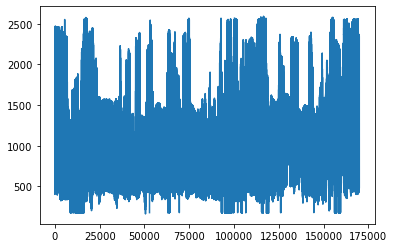

In [26]:
import matplotlib.pyplot as plt
temp = tracesx[:,0,4].sum(1)
plt.plot(temp)
plt.show()



In [51]:
#########################################################################
######################### MAKE VIDEOS ###################################
#########################################################################
import cv2
import matplotlib

#          pup1     pup2    female  male
colors_4= ['orange','green', 'blue', 'red', 'cyan','white','yellow','pink']

video_name = '/media/cat/4TBSSD/dan/march_2/sleap_talmo/2020-3-9_12_14_22_815059_compressed.avi'
original_vid = cv2.VideoCapture(video_name)


# SELECT VIDEO SIZE
size_vid = np.array([1280,1024])
scale = 1
dot_size = 8//scale

# SET START AND END TIMES
start = 0
end = 299+1
end = len(valid_frame_idxs)
end = 3000
print ("START: ", start, "   END: ", end)

# SELECT VIDEOS OUT
#out_dir = '/media/cat/4TBSSD/dan/march_2/madeline_dlc/2020-3-9_08_18_49_128168/'
fname_out = video_name[:-4]+"_corrected_"+str(start)+"_"+str(end)+".mp4"
fourcc = cv2.VideoWriter_fourcc('M','P','E','G')
video_out = cv2.VideoWriter(fname_out,fourcc, 25, (size_vid[0]//scale,size_vid[1]//scale), True)


original_vid.set(cv2.CAP_PROP_POS_FRAMES, start)

font = cv2.FONT_HERSHEY_PLAIN

ctr_sleap = 0
for n in trange(start,end, 1):
    ret, frame = original_vid.read()
    #print (n, frame.shape)
    cv2.putText(frame, str(n), (50, 100), font, 5, (255, 255, 0), 5)
    frame = frame[::scale, ::scale]
    
    # LOAD ALL LAbELS AT THIS TRACES
    while True:
        temp = traces[ctr_sleap]
        #print (temp)
        frame_id = int(temp[1])
        track_id = int(temp[0].replace('track_',''))
        
        # TRACK TEXT
        track_text = True
        #print (locs1)
        
        # EXIT WHEN HITTING NEXT FRAME INFO
        if frame_id>n:
            break
        
        # 
        locs1 = np.array(temp[2:])  # LOAD x,y locations

        y_array = locs1[::2]
        #print (x_array)
        x_array = locs1[1::2]
        
        for k in range(len(x_array)):
            x = x_array[k]
            y = y_array[k]
            
            if x=='' or y=='':
                continue
            else:
                x=int(float(x))//scale
                y=int(float(y))//scale

                if track_text:
                    cv2.putText(frame, str(track_id), (y,x), font, 5, (255, 255, 0), 5)
                    track_text=False
                
                frame[x-dot_size:x+dot_size,y-dot_size:y+dot_size]= (np.float32(
                    matplotlib.colors.to_rgb(colors_4[track_id%8]))*255.).astype('uint8')
                #print (colors_4[k])
                #frame[y-dot_size:y+dot_size,x-dot_size:x+dot_size]= (np.float32(
                #    matplotlib.colors.to_rgb(colors_4[z//14]))*255.).astype('uint8')
                
        ctr_sleap+=1

    #print ("")
    video_out.write(frame)

    #print ("")

video_out.release()
original_vid.release()
#cv2.destroyAllWindows()

  0%|          | 8/3000 [00:00<00:39, 74.92it/s]

START:  0    END:  3000


100%|██████████| 3000/3000 [00:40<00:00, 74.05it/s]


In [70]:
import cv2
import matplotlib
matplotlib.use('Agg')


#          pup1     pup2    female  male
colors_4= ['orange','green', 'blue', 'red', 'cyan','white','yellow','pink']

video_name = '/media/cat/4TBSSD/dan/march_2/sleap_talmo/2020-3-9_12_14_22_815059_compressed.avi'
original_vid = cv2.VideoCapture(video_name)


# SELECT VIDEO SIZE
size_vid = np.array([1280,1024])
scale = 1
dot_size = 8//scale

# SET START AND END TIMES
start = 0
end = 299+1
end = len(valid_frame_idxs)
end = 3000
start=225
end=start+10

print ("START: ", start, "   END: ", end)

# SELECT VIDEOS OUT
#out_dir = '/media/cat/4TBSSD/dan/march_2/madeline_dlc/2020-3-9_08_18_49_128168/'
fname_out = video_name[:-4]+"_corrected_"+str(start)+"_"+str(end)+".mp4"
fourcc = cv2.VideoWriter_fourcc('M','P','E','G')
video_out = cv2.VideoWriter(fname_out,fourcc, 25, (size_vid[0]//scale,size_vid[1]//scale), True)


original_vid.set(cv2.CAP_PROP_POS_FRAMES, start)

font = cv2.FONT_HERSHEY_PLAIN

ctr_sleap = 0
ctr_show = 0

fig=plt.figure(figsize=(20,20))

for n in trange(start,end, 1):
    ret, frame = original_vid.read()
    #print (n, frame.shape)
    cv2.putText(frame, str(n), (50, 100), font, 5, (255, 255, 0), 5)
    frame = frame[::scale, ::scale]
    
    # LOAD ALL LAbELS AT THIS TRACES
    while True:
        temp = traces[ctr_sleap]
        #print (temp)
        frame_id = int(temp[1])
        track_id = int(temp[0].replace('track_',''))
        
#         if frame_id !=n:
#             ctr_sleap+=1

#             continue
        
        # TRACK TEXT
        track_text = True
        #print (locs1)
        
        # EXIT WHEN HITTING NEXT FRAME INFO
        if frame_id>n:
            break
        
        if frame_id<n:
            ctr_sleap+=1
            continue
        
        # 
        locs1 = np.array(temp[2:])  # LOAD x,y locations

        y_array = locs1[::2]
        #print (x_array)
        x_array = locs1[1::2]
        
        for k in range(len(x_array)):
            x = x_array[k]
            y = y_array[k]
            
            if x=='' or y=='':
                continue
            else:
                x=int(float(x))//scale
                y=int(float(y))//scale

                if track_text:
                    cv2.putText(frame, str(track_id), (y,x), font, 5, (255, 255, 0), 5)
                    track_text=False
                
                frame[x-dot_size:x+dot_size,y-dot_size:y+dot_size]= (np.float32(
                    matplotlib.colors.to_rgb(colors_4[track_id%8]))*255.).astype('uint8')

        
        ctr_sleap+=1

    ax=plt.subplot(2,5,ctr_show+1)
    plt.imshow(frame)
    plt.title(str(n))
    
    ctr_show+=1
fig.savefig('/home/cat/fig2.png',dpi=300)   

START:  225    END:  235


100%|██████████| 10/10 [00:00<00:00, 40.35it/s]
